In [1]:
import glob
import os

import pandas as pd
import numpy as np
import json
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from scipy.interpolate import interp1d
from geopy import distance
import math
import pytz
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

# Arccos

## Import data

In [2]:
# Read in json files as dictionaries.
with open(r'round.json') as f:
    rounds_data = [json.load(f)]
with open(r'terrain.json') as f:
    terrain_data = [json.load(f)]
with open(r'2020-12-03T12_20_14.080Z.json') as f:
    course_info = json.load(f)

In [3]:
rounds_data

[{'roundId': 6175751,
  'roundVersion': 226,
  'courseId': 19596,
  'userId': '69783540370211eb89ce5334d9db98d8',
  'startTime': '2020-12-17T12:04:09.000000Z',
  'endTime': '2020-12-17T15:46:13.485000Z',
  'noOfHoles': 18,
  'noOfShots': 76,
  'shouldIgnore': 'F',
  'teeId': 2,
  'isPrivate': 'F',
  'isVerified': 'F',
  'isEnded': 'T',
  'isDriverRound': 'F',
  'courseVersion': 3,
  'lastModifiedTime': '2020-12-17T15:46:30.227000Z',
  'noOfHolesOverride': None,
  'scoreOverride': None,
  'holes': [{'holeId': 1,
    'noOfShots': 6,
    'isGir': 'F',
    'putts': 2,
    'isSandSaveChance': 'F',
    'isSandSave': 'F',
    'startTime': '2020-12-17T12:09:12.338000Z',
    'endTime': '2020-12-17T12:24:05.173000Z',
    'shouldIgnore': 'F',
    'isFairWay': 'F',
    'isFairWayRight': 'F',
    'isFairWayLeft': 'T',
    'approachShotId': 4,
    'isUpDownChance': 'F',
    'isUpDown': 'F',
    'isFairWayUser': None,
    'isFairWayRightUser': None,
    'isFairWayLeftUser': None,
    'pinLat': 52.165

## Create raw dataframe

In [4]:
# Create courses dataframe.
arccos_course_info = pd.json_normalize(course_info, 'courses')

In [5]:
arccos_course_info

,courseId,name,longitude,latitude,city,state,country,noOfHoles,mensPar,womensPar,noOfTimesPlayed,rounds,avgDriveHcp,avgApproachHcp,avgChipHcp,avgSandHcp,avgPuttHcp
0,17321,Rye GC - Old,0.771753,50.939133,Rye,East Sussex,GB,18,68,68,1,[4050754],6.33,5.18,-10.02,NaN,-4.38
1,17326,Cape Cornwall GC,-5.699421,50.127289,Penzance,Cornwall,GB,18,70,70,1,[4958368],-4.45,-3.47,-3.21,NaN,-6.02
2,17823,Castle Royle GC,-0.816517,51.500093,Reading,Berkshire,GB,18,71,71,1,[5532484],-8.53,-4.52,6.60,4.98,4.17
3,18829,Burhill GC - Old,-0.421354,51.351306,Walton on Thames,Surrey,GB,18,70,73,1,[4495559],-20.26,-1.29,-30.00,-16.57,4.47
4,19541,Sunningdale GC - Old,-0.636586,51.381742,Sunningdale,Surrey,GB,18,70,73,3,"[4998326, 4807572, 4585422]",0.29,-6.66,-4.61,-1.59,-2.49
5,19574,Saunton GC - East,-4.201564,51.110231,Braunton,Devon,GB,18,71,70,1,[3797878],-5.15,-2.46,-19.61,NaN,2.37
6,19707,Berkshire GC - Blue,-0.713107,51.383941,Ascot,Berkshire,GB,18,71,72,1,[4805188],-3.96,-2.53,-1.53,NaN,0.82
7,19835,Royal North Devon GC - 18,-4.223751,51.055630,Bideford,Devon,GB,18,72,73,12,"[5813864, 5344592, 5333676, 5324737, 5315536, ...",1.32,-0.91,-0.62,-7.74,-0.36
8,29040,Saint Georges Hill GC - Red/Blue,-0.450704,51.346948,Weybridge,Surrey,GB,18,70,70,2,"[5856697, 5731839]",3.70,-3.12,0.42,3.31,-0.87


In [6]:
def get_key_list(round_data):
   """Get key list from round data without the 'shot' key"""
   item = round_data[0]
   key_list = list(item['holes'][0].keys())
   key_list.remove('shots')
   return key_list


print(get_key_list(rounds_data))

['holeId', 'noOfShots', 'isGir', 'putts', 'isSandSaveChance', 'isSandSave', 'startTime', 'endTime', 'shouldIgnore', 'isFairWay', 'isFairWayRight', 'isFairWayLeft', 'approachShotId', 'isUpDownChance', 'isUpDown', 'isFairWayUser', 'isFairWayRightUser', 'isFairWayLeftUser', 'pinLat', 'pinLong', 'scoreOverride']


In [8]:
# Create shot dataframe.

## Convert hole_info to dataframe.
appended_data = []
for item in rounds_data:
    key_list = list(item['holes'][0].keys())
    key_list = list(set(key_list) - set(['shots']))
    shot_data = pd.json_normalize(item['holes'],
                                  'shots',
                                  key_list,
                                  record_prefix='shot_',
                                  meta_prefix='hole_')
    shot_data['roundId'] = item['roundId']
    appended_data.append(shot_data)
    
arccos_hole_info = pd.concat(appended_data)

## Convert round info to dataframe.
arccos_round_info = pd.DataFrame(rounds_data)
arccos_round_info.columns = ['round_' + column for column in arccos_round_info.columns]

## Merge hole and round info and drop round_holes column.
arccos_hole_info = arccos_hole_info.merge(arccos_round_info,
                                          left_on=['roundId'],
                                          right_on=['round_roundId'])
arccos_hole_info.drop(columns=['round_holes'], inplace=True)

## Convert numeric featurs to float/int.
numeric_features = ['shot_shotId', 'shot_clubType', 'shot_clubId', 'shot_startLat', 'shot_startLong',
                    'shot_endLat', 'shot_endLong', 'shot_distance', 'shot_startAltitude',
                    'shot_endAltitude', 'shot_noOfPenalties', 'hole_noOfShots', 'hole_pinLat',
                    'hole_pinLong', 'hole_putts', 'hole_holeId', 'hole_approachShotId', 'roundId',
                    'hole_noOfShots']
for i in numeric_features:
    arccos_hole_info[i] = pd.to_numeric(arccos_hole_info[i])

## Convert time features to datetime.
time_features = ['shot_shotTime', 'hole_startTime', 'hole_endTime', 'round_startTime', 'round_endTime']
for i in time_features:
    arccos_hole_info[i] = pd.to_datetime(arccos_hole_info[i])

## Convert boolean features.
boolean_map = {'T': True, 'F': False, 1: True, 0: False, 'None':None}
boolean_features = ['shot_isHalfSwing', 'shot_shouldIgnore', 'shot_isSandUser',
                    'shot_isNonSandUser', 'shot_shouldConsiderPuttAsChip', 'hole_isFairWayRight', 
                    'hole_isFairWayLeft', 'hole_scoreOverride', 'hole_isSandSave',
                    'hole_isUpDown', 'hole_isFairWayRightUser', 'hole_isFairWayUser',
                    'hole_isFairWayLeftUser', 'hole_isGir', 'hole_isFairWay',
                    'hole_isSandSaveChance']
arccos_hole_info[boolean_features] = arccos_hole_info[boolean_features].replace(boolean_map)

## Add course name.
arccos_course_name = arccos_course_info[['name', 'courseId']].drop_duplicates()
arccos_hole_info = arccos_hole_info.merge(arccos_course_name,
                                          how='left',
                                          left_on=['round_courseId'],
                                          right_on=['courseId'])

In [9]:
'fairway'.capitalize()

'Fairway'

In [10]:
t = ['a','a','b','c']
[e for e in t if e not in ['a','b']]

['c']

In [11]:
# Create shot dataframe with terrain data.

## Convert hole_info to dataframe.
appended_data = []
for item in terrain_data:
    key_list = list(item['holes'][0].keys())
    key_list = list(set(key_list) - set(['drive', 'approach', 'chip', 'sand']))
    drive_data = pd.json_normalize(item['holes'],
                                   'drive',
                                   key_list,
                                   record_prefix='shot_',
                                   meta_prefix='hole_')
    approach_data = pd.json_normalize(item['holes'],
                                      'approach',
                                      key_list,
                                      record_prefix='shot_',
                                      meta_prefix='hole_')
    chip_data = pd.json_normalize(item['holes'],
                                  'chip',
                                  key_list,
                                  record_prefix='shot_',
                                  meta_prefix='hole_')
    sand_data = pd.json_normalize(item['holes'],
                                  'sand',
                                  key_list,
                                  record_prefix='shot_',
                                  meta_prefix='hole_')
    shot_data = pd.concat([drive_data, approach_data, chip_data, sand_data], axis=0)
    shot_data['roundId'] = item['roundId']
    appended_data.append(shot_data)
    
arccos_hole_info_terrain = pd.concat(appended_data)

In [12]:
# Merge terrain data with shot data.
arccos_hole_info = arccos_hole_info.merge(
    arccos_hole_info_terrain[['roundId','hole_holeId', 'shot_shotId',
                              'hole_par', 'shot_startDistanceToCG',
                              'shot_startTerrain', 'shot_endTerrain']],
    how='left',
    left_on=['roundId', 'hole_holeId', 'shot_shotId'],
    right_on=['roundId', 'hole_holeId', 'shot_shotId'])

In [13]:
# Create arccos_data dataframe.
arccos_data = arccos_hole_info.copy()

## Prepare data

### Sort

In [14]:
# Sort data by player, date, round Id, hole Id and shot number.
arccos_data.sort_values(by=['round_userId', 'round_startTime', 'roundId', 'hole_holeId', 'shot_shotId'], inplace=True)

### Lies

In [15]:
# Fill last shot with 'In The Hole'.
arccos_data['shot_endTerrain'] = np.where(arccos_data['shot_shotId']==arccos_data['hole_noOfShots'],
                                          'In The Hole',
                                          arccos_data['shot_endTerrain'])

In [16]:
# Fill NaNs with 'Green'.
arccos_data['shot_startTerrain'] = arccos_data['shot_startTerrain'].fillna('Green')
arccos_data['shot_endTerrain'] = arccos_data['shot_endTerrain'].fillna('Green')

In [17]:
# Convert to Clippd lie names.
lie_dict = {'tee':'Tee', 'fairway':'Fairway', 'rough':'Rough',
            'sand':'Sand', 'green':'Green', 'Green':'Green',
            'In The Hole':'In The Hole'}
arccos_data['shot_startTerrain'] = arccos_data['shot_startTerrain'].map(lie_dict)
arccos_data['shot_endTerrain'] = arccos_data['shot_endTerrain'].map(lie_dict)

### Distances

In [18]:
# Calculate starting distance for each shot.
arccos_data['start_coordinates'] = list(zip(arccos_data['shot_startLat'],
                                            arccos_data['shot_startLong']))
arccos_data['pin_coordinates'] = list(zip(arccos_data['hole_pinLat'],
                                          arccos_data['hole_pinLong']))
arccos_data['shot_start_distance_yards'] = arccos_data.apply(
    lambda row: distance.distance(row['start_coordinates'], row['pin_coordinates']).ft/3, axis=1)

In [19]:
arccos_data['shot_startLat']

0     52.166023
1     52.166278
2     52.165971
3     52.166302
4     52.165967
        ...    
69    52.165353
70    52.165561
71    52.165566
72    52.165648
73    52.165625
Name: shot_startLat, Length: 74, dtype: float64

In [20]:
# Fill NaNs in end latitudes and longitudes and create end_coordinates column.
arccos_data['shot_endLat'].fillna(arccos_data['hole_pinLat'], inplace=True)
arccos_data['shot_endLong'].fillna(arccos_data['hole_pinLong'], inplace=True)
arccos_data['end_coordinates'] = list(zip(arccos_data['shot_endLat'],
                                          arccos_data['shot_endLong']))

# # Impute end_coordinates from next shot's start_coordinates.
# arccos_data['end_coordinates'] = arccos_data.groupby(['round_userId',
#                                                       'round_startTime',
#                                                       'roundId',
#                                                       'hole_holeId'])['start_coordinates'].shift(-1)
# arccos_data['end_coordinates'].fillna(arccos_data['pin_coordinates'], inplace=True)

In [21]:
# Calculate shot distance in yards using start and end coordinates.
arccos_data['shot_distance_yards_calculated'] = arccos_data.apply(
    lambda row: distance.distance(row['start_coordinates'], row['end_coordinates']).ft/3, axis=1)

In [22]:
# Calculate end distance for each shot.
arccos_data['shot_end_distance_yards'] = arccos_data.apply(
    lambda row: distance.distance(row['end_coordinates'], row['pin_coordinates']).ft/3, axis=1)
arccos_data['shot_end_distance_yards'].fillna(0, inplace=True)

In [23]:
# Take hole length as the distance to CG for first shot.
arccos_data['hole_yards'] = np.where(arccos_data['shot_shotId']==1,
                                     arccos_data['shot_startDistanceToCG'],
                                     np.nan)
arccos_data['hole_yards'].ffill(inplace=True)
arccos_data['hole_yards'] = pd.to_numeric(arccos_data['hole_yards'])

### Shot type

In [24]:
# Impute shot type.
conditions = [(arccos_data['shot_startTerrain']=='Tee')&(arccos_data['hole_par']!=3),
              (arccos_data['shot_start_distance_yards']<=30)&(arccos_data['shot_startTerrain']!='Green'),
              (arccos_data['shot_startTerrain']=='Green')]
values = ['TeeShot', 'GreensideShot', 'Putt']
arccos_data['shot_type'] = np.select(conditions, values, default='ApproachShot')

In [25]:
# Calculate z-scores for shot distance and start distance and by club and shot type.
arccos_data['shot_distance_yards_zscore'] = (arccos_data.groupby(['round_userId',
                                                                  'shot_type',
                                                                  'shot_clubType'])['shot_distance_yards_calculated']\
                                             .transform(lambda x : zscore(x, ddof=1))).fillna(0)
arccos_data['shot_start_distance_yards_zscore'] = (arccos_data.groupby(['round_userId',
                                                                        'shot_type',
                                                                        'shot_clubType'])['shot_start_distance_yards']\
                                                   .transform(lambda x : zscore(x, ddof=1))).fillna(0)

/home/alpha-omega/.local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/alpha-omega/.local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [26]:
# Impute shot subtype.
conditions = [arccos_data['shot_type']=='TeeShot',
              (arccos_data['shot_type']=='ApproachShot')&\
              (arccos_data['shot_distance_yards_zscore']<=-1)&\
              (arccos_data['shot_end_distance_yards']>30)&\
              (arccos_data['shot_endTerrain']!='Fairway'),
              (arccos_data['shot_type']=='ApproachShot')&\
              (arccos_data['shot_distance_yards_zscore']>-1)&\
              (arccos_data['shot_start_distance_yards_zscore']>1)&\
              (arccos_data['shot_end_distance_yards']>30),
              arccos_data['shot_type']=='GreensideShot',
              arccos_data['shot_type']=='Putt']
values = ['TeeShot', 'Recovery', 'LayUp', 'GreensideShot', 'Putt']
arccos_data['shot_subtype'] = np.select(conditions, values, default='GoingForGreen')

/home/alpha-omega/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/alpha-omega/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/alpha-omega/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/alpha-omega/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


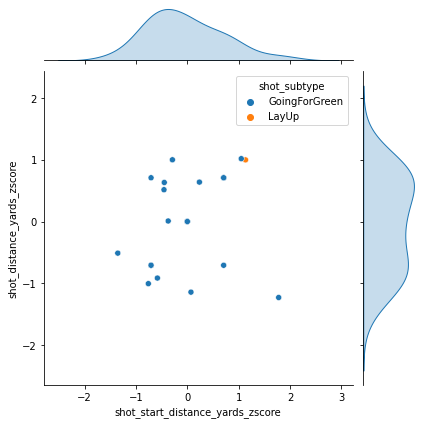

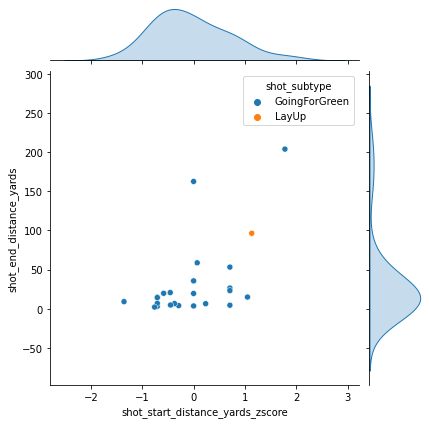

In [27]:
# Check shot subtype logic.
ax1 = sns.jointplot(data=arccos_data[arccos_data['shot_type']=='ApproachShot'],
                   x='shot_start_distance_yards_zscore',
                   y='shot_distance_yards_zscore',
                   hue='shot_subtype',
                   height=6)
ax2 = sns.jointplot(data=arccos_data[arccos_data['shot_type']=='ApproachShot'],
                   x='shot_start_distance_yards_zscore',
                   y='shot_end_distance_yards',
                   hue='shot_subtype',
                   height=6)

### Shot misses

In [28]:
# Determine shot miss directions and distances using coordinates and indicators.

## Function to get bearing between two points.
def get_bearing(start_coordinates, end_coordinates):
    lat1 = np.radians(start_coordinates[0])
    lon1 = np.radians(start_coordinates[1])
    lat2 = np.radians(end_coordinates[0])
    lon2 = np.radians(end_coordinates[1])
    dLon = lon2 - lon1;
    y = math.sin(dLon)*math.cos(lat2);
    x = math.cos(lat1)*math.sin(lat2) - math.sin(lat1)*math.cos(lat2)*math.cos(dLon);
    brng = np.rad2deg(math.atan2(y, x));
    if brng < 0:
        brng += 360
    return brng

## Function to calculate short/long distances.
def calculate_start_end_pin_angle(shot_distance, shot_start_distance_yards, shot_end_distance_yards):
    if (shot_end_distance_yards > 0)&(shot_distance > 0):
        phi = math.acos((shot_distance**2 + shot_end_distance_yards**2 - shot_start_distance_yards**2)\
                   /(2*shot_distance*shot_end_distance_yards))
    else:
        phi = 0
    return np.rad2deg(phi)

## Function to calculate left/right distances.
def calculate_miss_distance(miss_bearing_left_right, start_end_pin_angle, shot_end_distance_yards):
    if miss_bearing_left_right > 180:
        alpha = 180 - (360 - miss_bearing_left_right) - start_end_pin_angle
    else:
        alpha = 180 - miss_bearing_left_right - start_end_pin_angle
        
    if start_end_pin_angle > 90:
        if miss_bearing_left_right > 180:
            distance_left_right = -shot_end_distance_yards*math.sin(np.radians(alpha))
        else:
            distance_left_right = shot_end_distance_yards*math.sin(np.radians(alpha))
        distance_short_long = -shot_end_distance_yards*math.cos(np.radians(alpha))
    else:
        if miss_bearing_left_right > 180:
            distance_left_right = -shot_end_distance_yards*math.sin(np.radians(180 - alpha))
        else:
            distance_left_right = shot_end_distance_yards*math.sin(np.radians(180 - alpha))
        distance_short_long = shot_end_distance_yards*math.cos(np.radians(180 - alpha))
        
    return distance_left_right, distance_short_long


## Determine miss direction.
arccos_data['start_to_end_bearing'] = arccos_data.apply(
    lambda row: get_bearing(row['start_coordinates'], row['end_coordinates']), axis=1)
arccos_data['start_to_pin_bearing'] = arccos_data.apply(
    lambda row: get_bearing(row['start_coordinates'], row['pin_coordinates']), axis=1)
arccos_data['miss_bearing_left_right'] = arccos_data['start_to_end_bearing'] - arccos_data['start_to_pin_bearing']
arccos_data['miss_bearing_left_right'] = np.where(arccos_data['miss_bearing_left_right']<0,
                                                  arccos_data['miss_bearing_left_right']+360,
                                                  arccos_data['miss_bearing_left_right'])

## Determine miss distances.
arccos_data['end_to_pin_bearing'] = arccos_data.apply(
    lambda row: get_bearing(row['end_coordinates'], row['pin_coordinates']), axis=1)
arccos_data['start_end_pin_angle'] = arccos_data.apply(
    lambda row: calculate_start_end_pin_angle(row['shot_distance_yards_calculated'],
                                              row['shot_start_distance_yards'],
                                              row['shot_end_distance_yards']), axis=1)
arccos_data['shot_miss_distance'] = arccos_data.apply(
    lambda row: calculate_miss_distance(row['miss_bearing_left_right'],
                                        row['start_end_pin_angle'],
                                        row['shot_end_distance_yards']), axis=1)

arccos_data[['shot_miss_distance_left_right',
             'shot_miss_distance_short_long']] = pd.DataFrame(arccos_data['shot_miss_distance'].tolist(),
                                                              index=arccos_data.index)

## Impute left/right and short_long miss directions for approach shots.
conditions = [(arccos_data['shot_type']=='ApproachShot')&(arccos_data['hole_isGir']==False)&\
              (arccos_data['shot_miss_distance_left_right']<0),
              (arccos_data['shot_type']=='ApproachShot')&(arccos_data['hole_isGir']==False)&\
              (arccos_data['shot_miss_distance_left_right']>0)]
values = ['Left', 'Right']
arccos_data['shot_miss_direction_left_right'] = np.select(conditions, values, default=np.nan)
conditions = [(arccos_data['shot_type']=='ApproachShot')&(arccos_data['hole_isGir']==False)&\
              (arccos_data['shot_miss_distance_short_long']<0),
              (arccos_data['shot_type']=='ApproachShot')&(arccos_data['hole_isGir']==False)&\
              (arccos_data['shot_miss_distance_short_long']>0)]
values = ['Short', 'Long']
arccos_data['shot_miss_direction_short_long'] = np.select(conditions, values, default=np.nan)
            

## Use miss distance information to impute miss_direction.
conditions = [(arccos_data['shot_type']=='TeeShot')&(arccos_data['hole_isFairWayRight']==True),
              (arccos_data['shot_type']=='TeeShot')&(arccos_data['hole_isFairWayLeft']==True),
              (arccos_data['shot_type']=='ApproachShot')&(arccos_data['hole_isGir']==False)]
values = ['Right',
          'Left',
          (arccos_data['shot_miss_direction_short_long']
           + ' '
           + arccos_data['shot_miss_direction_left_right'])]
arccos_data['shot_miss_direction_all_shots'] = np.select(conditions, values, default=np.nan)

### Strokes gained

In [29]:
# Import PGA benchmark and define functions.

## Import PGA benchmark.
tee_app_arg = pd.read_csv('PGA Benchmark.csv')
put = pd.read_csv('PGA Putting Benchmark.csv')
put['Distance'] = put['Distance (feet)']/3

## Set up interpolation functions.
expected_shots_tee = interp1d(tee_app_arg[['Distance', 'Tee']].dropna()['Distance'],
                              tee_app_arg[['Distance', 'Tee']].dropna()['Tee'],
                              kind='linear',
                              fill_value='extrapolation')
expected_shots_fairway = interp1d(tee_app_arg[['Distance', 'Fairway']].dropna()['Distance'],
                                  tee_app_arg[['Distance', 'Fairway']].dropna()['Fairway'],
                                  kind='linear',
                                  fill_value='extrapolation')
expected_shots_rough = interp1d(tee_app_arg[['Distance', 'Rough']].dropna()['Distance'],
                                tee_app_arg[['Distance', 'Rough']].dropna()['Rough'],
                                kind='linear',
                                fill_value='extrapolation')
expected_shots_sand = interp1d(tee_app_arg[['Distance', 'Sand']].dropna()['Distance'],
                               tee_app_arg[['Distance', 'Sand']].dropna()['Sand'],
                               kind='linear',
                               fill_value='extrapolation')
expected_shots_green = interp1d(put['Distance'], put['Expected putts'], kind='linear')

## Define functions.
def expected_shots(x, lie):
    if lie=='Tee':
        average_number_of_shots = expected_shots_tee(x)
    elif lie=='Fairway':
        average_number_of_shots = expected_shots_fairway(x)
    elif lie=='Rough':
        average_number_of_shots = expected_shots_rough(x)
    elif lie=='Sand':
        average_number_of_shots = expected_shots_sand(x)
    elif lie=='Green':
        average_number_of_shots = expected_shots_green(x)
    elif lie=='In The Hole':
        average_number_of_shots = 0
    else:
        average_number_of_shots = np.nan
    return average_number_of_shots

def strokes_gained_calculation(start_lie, start_distance, end_lie, end_distance, shot_number, next_shot_number):
    start_average_number_of_shots = expected_shots(start_distance, start_lie)
    end_average_number_of_shots = expected_shots(end_distance, end_lie)
    if next_shot_number:
        strokes_gained = start_average_number_of_shots - end_average_number_of_shots - 1
    else:
        strokes_gained = (start_average_number_of_shots - end_average_number_of_shots
                          - (next_shot_number - shot_number))
    return strokes_gained

In [30]:
# Strokes gained using PGA benchmark.

## Impute next shot number.
arccos_data.sort_values(by=['round_userId', 'round_startTime', 'roundId', 'hole_holeId', 'shot_shotId'], inplace=True)
arccos_data['next_shot_shotId'] = arccos_data.groupby(['round_userId',
                                                       'round_startTime',
                                                       'roundId',
                                                       'hole_holeId'])['shot_shotId'].shift(-1)

## Calculate strokes gained.
arccos_data['strokes_gained_calculated'] = arccos_data.apply(lambda row: strokes_gained_calculation(row['shot_startTerrain'],
                                                                                                    row['shot_start_distance_yards'],
                                                                                                    row['shot_endTerrain'],
                                                                                                    row['shot_end_distance_yards'],
                                                                                                    row['shot_shotId'],
                                                                                                    row['next_shot_shotId']), axis=1)

## Mapping

In [31]:
# Import data dictionary and extract entries relevant to GSL.
data_dictionary = pd.read_excel('data_dictionary.xlsx')
arccos_data_dictionary = data_dictionary[['Clippd', 'Arccos']]
arccos_data_dictionary = arccos_data_dictionary.dropna().set_index('Arccos').to_dict()['Clippd']

In [32]:
# Filter relevant columns, apply data dictionary and add data_source field.
filtered_columns = list(arccos_data_dictionary.keys())
filtered_columns.remove("'arccos'")
arccos_data = arccos_data[filtered_columns].copy()
arccos_data.columns = arccos_data.columns.to_series().map(arccos_data_dictionary)
arccos_data['data_source'] = 'arccos'

In [33]:
arccos_data.head()

,player_id,round_time,shot_time,course_id,round_id,holes_played,round_score,hole_id,hole_par,hole_yards,...,shot_end_lie,shot_end_distance_yards,shot_distance_yards,shot_miss_direction,shot_miss_distance_short_long,shot_miss_distance_left_right,shot_strokes_gained,pin_long,pin_lat,data_source
0,69783540370211eb89ce5334d9db98d8,2020-12-17 12:04:09+00:00,2020-12-17 12:09:12.338000+00:00,19596,6175751,18,76,1,5,437.236,...,Rough,294.633850,189.581822,Left,-292.292407,-37.070933,-0.611298,0.172659,52.165892,arccos
1,69783540370211eb89ce5334d9db98d8,2020-12-17 12:04:09+00:00,2020-12-17 12:14:59.576000+00:00,19596,6175751,18,76,1,5,437.236,...,Fairway,203.817728,94.923282,Short Right,-202.534975,22.830903,-0.333597,0.172659,52.165892,arccos
2,69783540370211eb89ce5334d9db98d8,2020-12-17 12:04:09+00:00,2020-12-17 12:18:54.682000+00:00,19596,6175751,18,76,1,5,437.236,...,Rough,53.221256,189.491945,Short Left,-20.802613,-48.987277,-0.668070,0.172659,52.165892,arccos
3,69783540370211eb89ce5334d9db98d8,2020-12-17 12:04:09+00:00,2020-12-17 12:22:14.220000+00:00,19596,6175751,18,76,1,5,437.236,...,Green,9.182940,45.238527,Short Left,-8.175601,-4.181619,-0.071564,0.172659,52.165892,arccos
4,69783540370211eb89ce5334d9db98d8,2020-12-17 12:04:09+00:00,2020-12-17 12:23:44.916000+00:00,19596,6175751,18,76,1,NaN,437.236,...,Green,5.401123,3.980267,NaN,-5.316678,-0.951345,-0.851211,0.172659,52.165892,arccos


# Clippd dataframe

In [34]:
# Create empty Clippd dataframe.
data_dictionary = pd.read_excel('data_dictionary.xlsx')
clippd_data = pd.DataFrame(columns=data_dictionary['Clippd'].values)

In [35]:
# Add data to Clippd dataframe.

## Sort.
arccos_data.sort_values(by=['player_id', 'round_time', 'round_id', 'hole_id', 'shot_id'], inplace=True)

## Concatenate data sources.
clippd_data = pd.concat([clippd_data, arccos_data])
clippd_data.reset_index(drop=True, inplace=True)

In [36]:
clippd_data.columns

Index(['player_id', 'data_source', 'round_time', 'shot_time', 'course_id',
       'round_id', 'holes_played', 'round_score', 'hole_id', 'hole_par',
       'hole_yards', 'hole_score', 'shot_id', 'shot_category', 'shot_type',
       'club_id', 'shot_start_long', 'shot_start_lat', 'shot_start_lie',
       'shot_start_distance_yards', 'shot_end_long', 'shot_end_lat',
       'shot_end_lie', 'shot_end_distance_yards', 'shot_distance_yards',
       'shot_miss_direction', 'shot_miss_distance_short_long',
       'shot_miss_distance_left_right', 'shot_strokes_gained', 'pin_long',
       'pin_lat'],
      dtype='object')

In [37]:
# Tidy datetime features and add round_date.
datetime_features = ['round_time', 'shot_time']
for i in datetime_features:
    clippd_data[i] = clippd_data[i].apply(lambda x: x.replace(tzinfo=pytz.UTC))
    
clippd_data['round_date'] = pd.to_datetime(clippd_data['round_time']).dt.date

In [38]:
# Convert data_source to categorical variable and order dataframe.
clippd_data['data_source'] = pd.Categorical(clippd_data['data_source'],
                                            categories=['arccos', 'gsl', 'whs'], ordered=True)
clippd_data.sort_values(by=['data_source', 'player_id', 'round_time', 'round_id', 'hole_id'], inplace=True)

In [39]:
clippd_data.head(10)

,player_id,data_source,round_time,shot_time,course_id,round_id,holes_played,round_score,hole_id,hole_par,...,shot_end_lie,shot_end_distance_yards,shot_distance_yards,shot_miss_direction,shot_miss_distance_short_long,shot_miss_distance_left_right,shot_strokes_gained,pin_long,pin_lat,round_date
0,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 12:09:12.338000+00:00,19596,6175751,18,76,1,5,...,Rough,294.633850,189.581822,Left,-292.292407,-37.070933,-0.611298,0.172659,52.165892,2020-12-17
1,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 12:14:59.576000+00:00,19596,6175751,18,76,1,5,...,Fairway,203.817728,94.923282,Short Right,-202.534975,22.830903,-0.333597,0.172659,52.165892,2020-12-17
2,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 12:18:54.682000+00:00,19596,6175751,18,76,1,5,...,Rough,53.221256,189.491945,Short Left,-20.802613,-48.987277,-0.668070,0.172659,52.165892,2020-12-17
3,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 12:22:14.220000+00:00,19596,6175751,18,76,1,5,...,Green,9.182940,45.238527,Short Left,-8.175601,-4.181619,-0.071564,0.172659,52.165892,2020-12-17
4,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 12:23:44.916000+00:00,19596,6175751,18,76,1,NaN,...,Green,5.401123,3.980267,NaN,-5.316678,-0.951345,-0.851211,0.172659,52.165892,2020-12-17
5,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 12:24:05.173000+00:00,19596,6175751,18,76,1,NaN,...,In The Hole,0.000000,5.401123,NaN,0.000000,0.000000,0.805661,0.172659,52.165892,2020-12-17
6,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 12:30:06.312000+00:00,19596,6175751,18,76,2,4,...,Rough,78.802003,266.287568,Left,-74.724071,-25.021371,-0.097000,0.177634,52.165613,2020-12-17
7,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 12:36:49.437000+00:00,19596,6175751,18,76,2,4,...,Fairway,58.706081,28.608345,NaN,-56.101183,17.293384,-0.738418,0.177634,52.165613,2020-12-17
8,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 12:37:58.233000+00:00,19596,6175751,18,76,2,4,...,Green,3.657862,62.204191,NaN,3.488345,1.100638,0.032828,0.177634,52.165613,2020-12-17
9,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 12:39:07.280000+00:00,19596,6175751,18,76,2,NaN,...,In The Hole,0.000000,3.657862,NaN,0.000000,0.000000,0.661996,0.177634,52.165613,2020-12-17


In [40]:
clippd_data.tail(5)

,player_id,data_source,round_time,shot_time,course_id,round_id,holes_played,round_score,hole_id,hole_par,...,shot_end_lie,shot_end_distance_yards,shot_distance_yards,shot_miss_direction,shot_miss_distance_short_long,shot_miss_distance_left_right,shot_strokes_gained,pin_long,pin_lat,round_date
69,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 15:36:34.519000+00:00,19596,6175751,18,76,18,4,...,Rough,179.575221,258.471564,Right,-179.308493,9.783877,-0.235521,0.166221,52.165569,2020-12-17
70,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 15:41:39.330000+00:00,19596,6175751,18,76,18,4,...,Fairway,96.381098,83.194498,Short Right,-96.380925,0.182545,-0.480842,0.166221,52.165569,2020-12-17
71,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 15:43:07.513000+00:00,19596,6175751,18,76,18,4,...,Green,14.996576,85.520055,Short Right,-11.418577,9.721799,-0.308775,0.166221,52.165569,2020-12-17
72,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 15:45:57.356000+00:00,19596,6175751,18,76,18,NaN,...,Green,7.124296,13.703415,NaN,-2.934424,6.491899,-0.791733,0.166221,52.165569,2020-12-17
73,69783540370211eb89ce5334d9db98d8,arccos,2020-12-17 12:04:09+00:00,2020-12-17 15:46:13.485000+00:00,19596,6175751,18,76,18,NaN,...,In The Hole,0.000000,7.124296,NaN,0.000000,0.000000,0.889651,0.166221,52.165569,2020-12-17


In [41]:
# clippd_data.to_pickle('clippd_data.pkl')